In [ ]:
!pip install gensim==3.8.3 --quiet
!pip install pydot --quiet
!pip install sentencepiece --quiet
!pip install transformers --quiet

     |████████████████████████████████| 24.2 MB 797 kB/s 
     |████████████████████████████████| 1.2 MB 15.9 MB/s 
     |████████████████████████████████| 4.4 MB 14.8 MB/s 
     |████████████████████████████████| 596 kB 85.1 MB/s 
     |████████████████████████████████| 101 kB 13.9 MB/s 
     |████████████████████████████████| 6.6 MB 57.9 MB/s 


In [ ]:
from google.cloud import storage
import google.oauth2.credentials
import json
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

import sklearn as sk
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim


## Load Yelp data
Get both the reviews data set and the corresponding business data set

In [ ]:
# Access to google drive where I have downloded the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import pandas as pd
data_file = open("/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_academic_dataset_business.json")
data = []
for line in data_file:
  data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

In [ ]:
business_df = business_df.convert_dtypes()
business_df[0:5]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
data_file = open("/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_academic_dataset_review.json")
data = []
for line in data_file:
  data.append(json.loads(line))
review_df = pd.DataFrame(data)
data_file.close()

In [ ]:
review_df = review_df.convert_dtypes()
review_df[0:5]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [ ]:
# join data sets together
review_df = review_df.join(business_df.set_index('business_id'), how = "left", lsuffix='_review', on = 'business_id')

In [ ]:
# Get only reviews for businesses categorized as a 'Restaurant'
review_df = review_df[(review_df.categories.str.contains('Restaurants'))]

In [ ]:
review_df.describe()

,stars_review,useful,funny,cool,latitude,longitude,stars,review_count,is_open
count,4.724471e+06,4.724471e+06,4.724471e+06,4.724471e+06,4.724471e+06,4.724471e+06,4.724471e+06,4.724471e+06,4.724471e+06
mean,3.793798e+00,9.840992e-01,3.013692e-01,4.795771e-01,3.587026e+01,-8.903109e+01,3.792529e+00,4.925801e+02,7.987709e-01
std,1.391227e+00,2.739150e+00,1.717190e+00,2.159917e+00,5.337905e+00,1.429694e+01,6.258164e-01,8.502007e+02,4.009189e-01
min,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,2.756446e+01,-1.200837e+02,1.000000e+00,5.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.995987e+01,-9.023588e+01,3.500000e+00,9.000000e+01,1.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.859945e+01,-8.615980e+01,4.000000e+00,2.210000e+02,1.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.994374e+01,-7.545180e+01,4.000000e+00,5.080000e+02,1.000000e+00
max,5.000000e+00,4.200000e+02,7.920000e+02,4.040000e+02,5.367920e+01,-7.466446e+01,5.000000e+00,7.568000e+03,1.000000e+00


In [ ]:
# only keep the review text and the usefulness column, which we'll use a proxy for the binary label of 'helpful'
review_df = review_df[['text', 'useful']]

In [ ]:
# Take a look at the distribution of usefulness votes
review_df.groupby(by='useful').apply(lambda x: (x['text'].count() / review_df.shape[0])*100)

useful
-1       0.000021
 0      58.319291
 1      21.973762
 2       9.171461
 3       4.298449
          ...    
 392     0.000021
 399     0.000042
 400     0.000021
 404     0.000021
 420     0.000021
Length: 225, dtype: float64

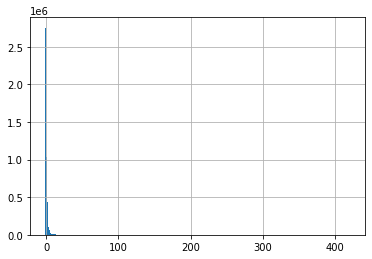

In [ ]:
review_df.useful.hist(bins=420)
# Can see that most of the votes are concentrated in 0-10, not may reviews have a large amount of votes but the tail is very long

In [ ]:
# If we class 'useful' as anything with 4 of more votes, anything with 1-3 votes we discard and anything with 0 votes is classed as 'unhelpful'
# another way to do this could be to look at the total number of helpful votes across all reviews for a business and determine the share of helpful votes a review has, 
# and then create a cut off for 'helpful' vs. 'unhelpful'
# We also may want to remove reviews for business where there have been no reviews marked as helpful, as this could just be to lack of visibility rather than their unhelpfulness.

# subset data to our classification of helpful and unhelpful
review_df = review_df[(review_df.useful > 3) | (review_df.useful == 0)]
# now convert to binary labels
review_df['label'] = np.where((review_df.useful > 3), 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# Check the balance
review_df.groupby(by='label').apply(lambda x: (x['text'].count()*100)/review_df.shape[0])

label
0    90.338642
1     9.661358
dtype: float64

In [ ]:
# Checking the length of the reviews across helpful and unhelpful labels
review_df.groupby(by='label').apply(lambda x: x['text'].str.len().mean())
# Unhelpful reviews tend to be shorter than helpful ones

label
0     427.292856
1    1092.766427
dtype: float64

In [ ]:
# Save text length as a variable as it is used in the most recent paper found for this problem space
review_df['text_length'] = review_df['text'].str.len()

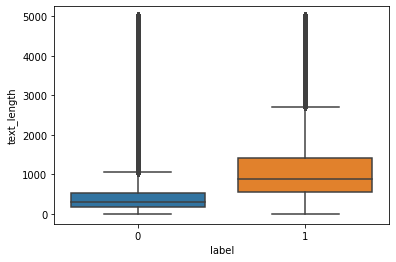

In [ ]:
sns.boxplot(x="label", y="text_length", data=review_df);

## Create train and test data

In [ ]:
# We have a big class imbalance in our dataset, we'll correct this by doing some undersampling on the negative class

# Find out how many postive labels we have:
positive_samples = review_df[(review_df.label == 1)]
n_positive_samples = positive_samples.shape[0]

# Sample from negative class so we have the same amount:
negative_samples = review_df[(review_df.label == 0)].sample(n=n_positive_samples)

balanced_df = positive_samples.append(negative_samples)

In [ ]:
# Check balance
balanced_df.groupby(by='label').count()

,text,useful,text_length
label,,,
0,294666,294666,294666
1,294666,294666,294666


In [ ]:
from sklearn.model_selection import train_test_split
# We have ~600k rows, trimming down to ~60k for speed
sampled_df = balanced_df.sample(frac=0.1)
x = list(sampled_df[['text']].text)
y = list(sampled_df[['label']].label)
x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size=0.8)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, train_size=0.5)

print(f"Shape X_train: {len(x_train)}")
print(f"Shape X_valid: {len(x_valid)}")
print(f"Shape X_test: {len(x_test)}")

Shape X_train: 47146
Shape X_valid: 5893
Shape X_test: 5894


In [ ]:
#pd.DataFrame({'text': x_train, 'label': y_train}).to_csv('/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_train.csv', index = False)
#pd.DataFrame({'text': x_test, 'label': y_test}).to_csv('/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_test.csv', index = False)
#pd.DataFrame({'text': x_valid, 'label': y_valid}).to_csv('/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_valid.csv', index = False)

In [ ]:
# Getting a larger data set for comparison:
from sklearn.model_selection import train_test_split
sampled_df = balanced_df
x = list(sampled_df[['text']].text)
y = list(sampled_df[['label']].label)
x_train_large, x_rem_large, y_train_large, y_rem_large= train_test_split(x, y, train_size=0.8)
x_valid_large, x_test_large, y_valid_large, y_test_large = train_test_split(x_rem_large, y_rem_large, train_size=0.5)

print(f"Shape X_train: {len(x_train_large)}")
print(f"Shape X_valid: {len(x_valid_large)}")
print(f"Shape X_test: {len(x_test_large)}")

pd.DataFrame({'text': x_train_large, 'label': y_train_large}).to_csv('/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_train_large.csv', index = False)
pd.DataFrame({'text': x_test_large, 'label': y_test_large}).to_csv('/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_test_large.csv', index = False)
pd.DataFrame({'text': x_valid_large, 'label': y_valid_large}).to_csv('/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_valid_large.csv', index = False)

Shape X_train: 471465
Shape X_valid: 58933
Shape X_test: 58934
